# Data integration with ICESat-2 - Part II

```{admonition} Learning Objectives
**Goals**
- Access NSIDC data sets and acquire IS-2 using icepyx
- Analyze point and raster data together with IS-2
- Advanced visualizations of multiple datasets
```
☝️ This formatting is a Jupyter Book [admonition](https://jupyterbook.org/content/content-blocks.html#notes-warnings-and-other-admonitions), that uses a custom version of Markdown called {term}`MyST`

## Libraries need to add:
* nisardev
* grimpfunc

# Plot Flowines Using Remote Greenland Ice Mapping Project Data
---

This notebook demonstrates how Greenland Ice Mapping Project can be remotely accessed to create plots along flowlines from [Felikson et al., 2020](https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2020GL090112), which are archived on [Zenodo](https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2020GL090112). The copies of the shapefiles included in this repository were downloaded in late January 2022. The notebook works with a specific set of glacier ids but is easily modified to plot results for other glaciers in the flowline data set.

In [2]:
from IPython.lib.deepreload import reload
%load_ext autoreload
%autoreload 2
import nisardev as nisar
import os
import matplotlib.colors as mcolors
import grimpfunc as grimp
import matplotlib.pyplot as plt
import geopandas as gpd
from datetime import datetime
import numpy as np
import xarray as xr
import importlib
import requests
import pyproj
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import panel
from dask.diagnostics import ProgressBar
ProgressBar().register()
panel.extension()

## NSIDC Login

For remote access to the velocity data at NSIDC, run these cells to login with your NASA EarthData Login (see  [NSIDCLoginNotebook](https://github.com/fastice/GRiMPNotebooks/blob/master/NSIDCLoginNotebook.ipynb) for further details). These cells can skipped if all data are being accessed locally. First define where the cookie files need for login are saved.

In [3]:
env = dict(GDAL_HTTP_COOKIEFILE=os.path.expanduser('~/.grimp_download_cookiejar.txt'),
            GDAL_HTTP_COOKIEJAR=os.path.expanduser('~/.grimp_download_cookiejar.txt'))
os.environ.update(env)

Now enter credentials. If previous valid cookie exists, no user input is needed.

In [4]:
myLogin = grimp.NASALogin()
myLogin.view()

Getting login from ~/.netrc
Already logged in. Proceed.


# Stuff for IPYLEAF

### Termini

Locate the files in the NSDIC catalog.

In [5]:
myTerminusUrls = grimp.cmrUrls(mode='terminus')  # mode image restricts search to the image products
myTerminusUrls.initialSearch();

Read in termini and store in a dict, `myTermini`, by year.

In [6]:
myTermini = {}
for url in myTerminusUrls.getURLS():
    print('.', end='')
    year = os.path.basename(url).split('_')[1]  # Extract year from name
    myTermini[year] = gpd.read_file(f'/vsicurl/&url={url}')  # Add terminus to data frame

.............

### Flowines

Read flowline by glacier.

In [7]:
glaciers = {}
for i in range(1, 3):
    glaciers[f'000{i}'] = gpd.read_file(f'shpfiles/glacier000{i}.shp');

### Plot Flowlines and Termini

Checking everything looks good before ipyleaf.

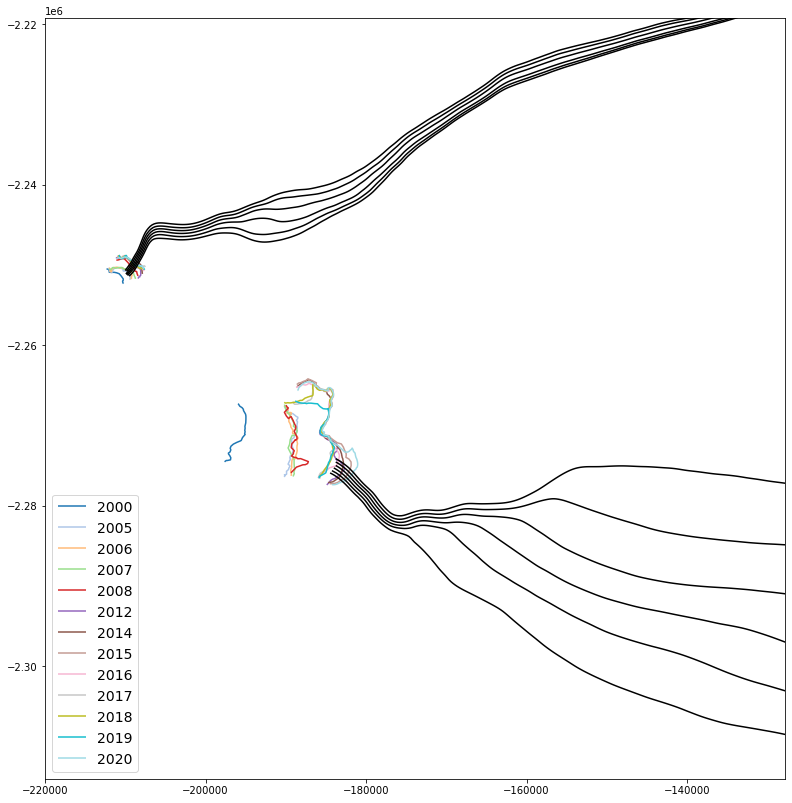

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(18, 14))
colors = {key: color for key, color in zip(myTermini, plt.cm.tab20(np.linspace(0, 1, len(myTermini))))}
#myVelSeries.displayVelForDate('2020-01-01', ax=ax, labelFontSize=12, plotFontSize=9, titleFontSize=14, 
#                              vmin=0, vmax=2000, units='m', scale='linear', colorBarSize='3%') 
#
# Termini - unfortunately numbers are slightly differnt
#
for i in range(3, 5):
    for key in myTermini:
         myTermini[key].loc[myTermini[key]['Glacier_ID'] == i].plot(ax=ax, label=key, color=colors[key])
for key in glaciers:
    glaciers[key].plot(ax=ax, color='k')
#
ax.set_xlim((-220000.0, -127800.0))
ax.set_ylim((-2314000.0, -2219200.0))
# Use years for legends       
h, l = ax.get_legend_handles_labels()
by_label = dict(zip(l, h)) # will overwrite identical entries to produce uniqe values
ax.legend(by_label.values(), by_label.keys(), loc='lower left', fontsize=14);

# End Stuff for IPYLEAF

## Read Shapefiles

In the examples presented here we will use glaciers 1 & 2  in the Felikson data base, [Felikson et al., 2020](https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2020GL090112), which were retrieved from [Zenodo](https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2020GL090112). 

Each glacier's flowlines are used to create `grimp.Flowlines` instances, which are saved in a dictionary, `myFlowlines` with glacier id: '0001' and  '0002'. Each `Flowlines` read a set of flowlines for each glacier and stores in a dictionary of `myFlowlines.flowlines`. The code to do this looks something like:

```
    flowlines = {}
    shapeTable = gpd.read_file(shapefile)
    for index, row in shapeTable.iterrows():  # loop over features
        fl = {}  # New Flowline
        fl['x'], fl['y'] = np.array([c for c in row['geometry'].coords]).transpose()
        fl['d'] = computeDistance(fl['x'], fl['y'])
        flowlines[row['flowline']] = fl
 ```
For further detail, see the full [class defintion](https://github.com/fastice/grimpfunc/blob/master/grimpfunc/Flowlines.py)

To limit the plots to the downstream regions, the flowlines are all truncated to a `length` of 50km. 

Within each myFlowines entry (a `grimp.Flowlines` instance), the individual flowlines are maintained as a dictionary `myFlowlines['glacierId'].flowlines`.

In [9]:
myShapeFiles = [f'./shpfiles/glacier000{i}.shp' for i in range(1, 3)] # Build list of shape file names
myFlowlines = {x[-8:-4]: grimp.Flowlines(shapefile=x, name=x[-8:-4], length=50e3) for x in myShapeFiles} 
myFlowlines

{'0001': <grimpfunc.Flowlines.Flowlines at 0x175bf0760>,
 '0002': <grimpfunc.Flowlines.Flowlines at 0x175e01730>}

Each flowline is indexed as shown here:

In [10]:
myFlowlines['0001'].flowlines.keys()

dict_keys(['03', '04', '05', '06', '07', '08'])

The data for the flow line is simple, just `x`, `y` polar stereographic coordinates (EPSG=3413) and the distance, `d`, from the start of the flowline.

In [11]:
myFlowlines['0001'].flowlines['03'].keys()

dict_keys(['x', 'y', 'd'])

These coordinates for a given index can be return as `myFlowlines['0001'].xym(index='03')` or `myFlowlines['0001'].xykm(index='03')`

The area of interest can be defined as the union of the bounds for all of the flowlines computed as shown below along with the unique set of flowline IDs across all glaciers.

In [12]:
myBounds = {'minx': 1e9, 'miny': 1e9, 'maxx': -1e9, 'maxy': -1e9}  # Initial bounds to force reset
flowlineIDs = []  # 
for myKey in myFlowlines:
    # Get bounding box for flowlines
    flowlineBounds = myFlowlines[myKey].bounds
    # Merge with prior bounds
    myBounds = myFlowlines[myKey].mergeBounds(myBounds, flowlineBounds)
    # Get the flowline ids
    flowlineIDs.append(myFlowlines[myKey].flowlineIDs())
# Get the unique list of flowlines ids (used for legends later)
flowlineIDs = np.unique(flowlineIDs)
print(myBounds)
print(flowlineIDs)

{'minx': -220000.0, 'miny': -2314100.0, 'maxx': -127800.0, 'maxy': -2219100.0}
['03' '04' '05' '06' '07' '08']


## Search Catalog for Velocity Data

We now need to locate velocity data from the GrIMP data set. For this excercise, we will focus on the annual velocity maps of Greenland. To do this, we will use the `grimp.cmrUrls` tool, which will do a GUI based search of NASA's Common Metadata Repository ([CMR](https://earthdata.nasa.gov/eosdis/science-system-description/eosdis-components/cmr)). Search parameters can be passe directly to `initialSearch` method to perform the search.

In [13]:
myUrls = grimp.cmrUrls(mode='nisar', verbose=True)  # nisar mode excludes image and tsx products and allows only one product type at a time
myUrls.initialSearch(product='NSIDC-0725')

https://cmr.earthdata.nasa.gov/search/granules.json?provider=NSIDC_ECS&sort_key[]=start_date&sort_key[]=producer_granule_id&scroll=false&page_size=2000&page_num=1&short_name=NSIDC-0725&version=3&temporal[]=2000-01-01T00:00:01Z,2022-03-14T00:23:59&bounding_box[]=-75.00,60.00,-5.00,82.00&producer_granule_id[]=*&options[producer_granule_id][pattern]=true


Row
    [0] Column(min_width=400)
        [0] Markdown(str)
        [1] Param(cmrUrls, name='Select Product &..., widgets={'product': <class 'panel....}, width=400)
        [2] Row
            [0] Markdown(str)
            [1] Markdown(str)
    [1] Column
        [0] ParamMethod(method)
        [1] ParamMethod(method)
        [2] ParamMethod(method)

The `verbose` flag causes the CMR search string to be printed. The search basically works by a) reading the parameters from the search panel (e.g., product, date, etc) and creating a search string, which returns the search result.

In [14]:
response = requests.get('https://cmr.earthdata.nasa.gov/search/granules.json?provider=NSIDC_ECS&sort_key[]=start_date&sort_key[]='
                        'producer_granule_id&scroll=false&page_size=2000&page_num=1&short_name=NSIDC-0725&version=3&temporal[]='
                        '2000-01-01T00:00:01Z,2022-03-10T00:23:59&bounding_box[]=-75.00,60.00,-5.00,82.00&producer_granule_id[]='
                        '*&options[producer_granule_id][pattern]=true')
search_results = response.json()
search_results;

Under the hood, the `cmrUrls` code can filter the json to get a list of urls:

In [15]:
myUrls.getURLS()

https://cmr.earthdata.nasa.gov/search/granules.json?provider=NSIDC_ECS&sort_key[]=start_date&sort_key[]=producer_granule_id&scroll=false&page_size=2000&page_num=1&short_name=NSIDC-0725&version=3&temporal[]=2000-01-01T00:00:01Z,2022-03-14T00:23:59&bounding_box[]=-75.00,60.00,-5.00,82.00&producer_granule_id[]=*&options[producer_granule_id][pattern]=true


['https://n5eil01u.ecs.nsidc.org/DP4/MEASURES/NSIDC-0725.003/2014.12.01/GL_vel_mosaic_Annual_01Dec14_30Nov15_vv_v03.0.tif',
 'https://n5eil01u.ecs.nsidc.org/DP4/MEASURES/NSIDC-0725.003/2015.12.01/GL_vel_mosaic_Annual_01Dec15_30Nov16_vv_v03.0.tif',
 'https://n5eil01u.ecs.nsidc.org/DP4/MEASURES/NSIDC-0725.003/2016.12.01/GL_vel_mosaic_Annual_01Dec16_30Nov17_vv_v03.0.tif',
 'https://n5eil01u.ecs.nsidc.org/DP4/MEASURES/NSIDC-0725.003/2017.12.01/GL_vel_mosaic_Annual_01Dec17_30Nov18_vv_v03.0.tif',
 'https://n5eil01u.ecs.nsidc.org/DP4/MEASURES/NSIDC-0725.003/2018.12.01/GL_vel_mosaic_Annual_01Dec18_30Nov19_vv_v03.0.tif',
 'https://n5eil01u.ecs.nsidc.org/DP4/MEASURES/NSIDC-0725.003/2019.12.01/GL_vel_mosaic_Annual_01Dec19_30Nov20_vv_v03.0.tif']

## Load the Velocity Data

GrIMP produces full Greenland velocity maps. Collectively, there are more than 400 full Greenland maps, totalling several hundred GB of data, which may be more than a user interested in a few glaciers wants to download and store on their laptop.  Fortunately using Cloud Optimized Geotiffs, which have the following properties:

- All the metadata is at the beginning of the file, allowing a single read to obtain the layout. 
- The data are tiled (i.e., stored as a series of blocks like a checkerboard) rather than as a line-by-line raster.  
- A consistent set of overview images (pyramids) are stored with the data.

While the velocity data are stored as multiple files at NSIDC, they can all be combined into a single `nisarVelSeries` instance, which has the following properties:

- Built on Xarray,
- Dask (arallel operations),
- Local and remote subsetting (Lazy Opens), and
- Subsets can be saved for later use

Before loading the data, we must setup the filename template. Specifically, we must put a '\*' where the band identifier would go and remove the trailing '.tif' extention. 

In [16]:
urlNames = [x.replace('vv','*').replace('.tif','') for x in myUrls.getCogs()] # getCogs filters to ensure tif products

In [17]:
myVelSeries = nisar.nisarVelSeries() # Create Series
myVelSeries.readSeriesFromTiff(urlNames, url=True, readSpeed=False)  # readSpeed=False computes speed from vx, vy rather than downloading
myVelSeries.xr  # Add semicolon after to suppress output

<xarray.DataArray 'VelocitySeries' (time: 6, band: 3, y: 13700, x: 7585)>
dask.array<concatenate, shape=(6, 3, 13700, 7585), dtype=float32, chunksize=(1, 1, 512, 512), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) <U2 'vx' 'vy' 'vv'
  * x            (x) float64 -6.59e+05 -6.588e+05 ... 8.576e+05 8.578e+05
  * y            (y) float64 -6.392e+05 -6.394e+05 ... -3.379e+06 -3.379e+06
    spatial_ref  int64 0
  * time         (time) datetime64[ns] 2015-06-01 ... 2020-05-31T12:00:00
    name         <U4 'None'
    _FillValue   float64 -2e+09
    time1        (time) datetime64[ns] 2014-12-01 2015-12-01 ... 2019-12-01
    time2        (time) datetime64[ns] 2015-11-30 2016-11-30 ... 2020-11-30

For the annual data set, this step produces a ~7GB data sets, which expands to 370GB for the full 6-12-day data set. To avoid downloading unnessary data, the data can be subsetted using the bounding box from the flowlines. 

In [18]:
myVelSeries.subSetVel(myBounds) # Apply subset
myVelSeries.subset # Add semicolon after to suppress output

<xarray.DataArray 'VelocitySeries' (time: 6, band: 3, y: 475, x: 462)>
dask.array<getitem, shape=(6, 3, 475, 462), dtype=float32, chunksize=(1, 1, 292, 365), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) <U2 'vx' 'vy' 'vv'
  * x            (x) float64 -2.2e+05 -2.198e+05 ... -1.28e+05 -1.278e+05
  * y            (y) float64 -2.219e+06 -2.219e+06 ... -2.314e+06 -2.314e+06
  * time         (time) datetime64[ns] 2015-06-01 ... 2020-05-31T12:00:00
    name         <U4 'None'
    _FillValue   float64 -2e+09
    time1        (time) datetime64[ns] 2014-12-01 2015-12-01 ... 2019-12-01
    time2        (time) datetime64[ns] 2015-11-30 2016-11-30 ... 2020-11-30
    spatial_ref  int64 0

The volume of the data set is now a far more manageable ~15MB, which is still located in the archive.  Operations can continue without downloading, but if lots of operations are going to occur, it is best to download the data upfront. 

In [19]:
myVelSeries.loadRemote() # Load the data to memory

[########################################] | 100% Completed | 27.7s


## Overview Images

In [20]:
myOverview = nisar.nisarVelSeries() # Create Series
myOverview.readSeriesFromTiff([urlNames[-1]], url=True, readSpeed=False, overviewLevel=3)  # readSpeed=False computes speed from vx, vy rather than downloading
myOverview.xr  # Add semicolon after to suppress output
myOverview.loadRemote()

[########################################] | 100% Completed |  1.6s


## Display Flowlines and Velocity

The flowlines over one of the velocity layers can be displayed as with the following block of code. In addition to plotting the flowline, a point 10 km along each flowline is plotted and saved for subsequent plots below.

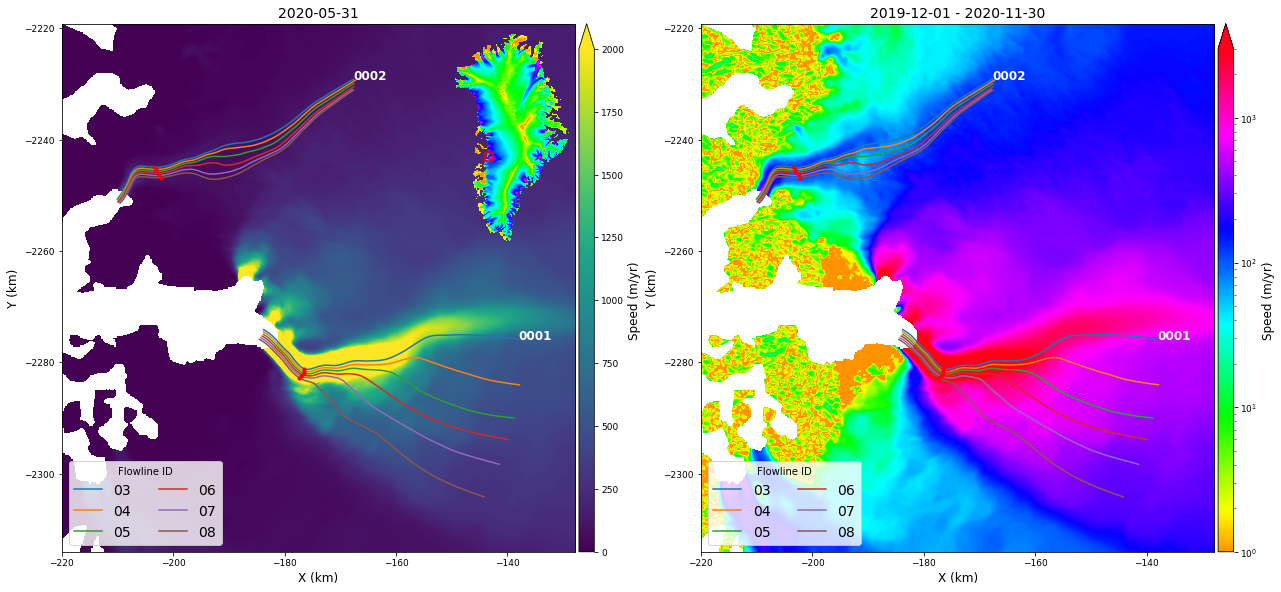

In [51]:
# set up figure and axis
fig, axes = plt.subplots(1, 2, figsize=(21, 12))
# Create a dictionary for accumulating glacier points
glacierPoints = {}
# generate a color dict that spans all flowline ids, using method from a flowline instance
flowlineColors = list(myFlowlines.values())[0].genColorDict(flowlineIDs=flowlineIDs)
# Plot velocity maps
# Saturate at 2000 m/yr to preserve slow detail
myVelSeries.displayVelForDate('2020-01-01', ax=axes[0], labelFontSize=12, plotFontSize=9, titleFontSize=14, 
                              vmin=0, vmax=2000, units='km', scale='linear', colorBarSize='3%') 
myVelSeries.displayVelForDate('2020-01-01', ax=axes[1], labelFontSize=12, plotFontSize=9, titleFontSize=14, 
                              vmin=1, vmax=3000, units='km', scale='log', midDate=False, colorBarSize='3%')
# Plot location inset
height = 3
axInset = inset_axes(axes[0], width=height * myOverview.sx/myOverview.sy, height=height, loc=1)
myOverview.displayVelForDate(None, ax=axInset, vmin=1, vmax=3000, colorBar=False, scale='log', title='')
axInset.plot(*myVelSeries.outline(), color='r')
axInset.axis('off')
#
# Loop over each glacier and plot the flowlines
for glacierId in myFlowlines:
    # Plot the flowline Match units to the map
    myFlowlines[glacierId].plotFlowlineLocations(ax=axes[0], units='km', colorDict=flowlineColors)
    myFlowlines[glacierId].plotFlowlineLocations(ax=axes[1], units='km', colorDict=flowlineColors)
    # 
    myFlowlines[glacierId].plotGlacierName(ax=axes[0], units='km', color='w', fontsize=12,fontweight='bold', first=False)
    myFlowlines[glacierId].plotGlacierName(ax=axes[1], units='km', color='w', fontsize=12,fontweight='bold', first=False)
    # Generates points 10km from downstream end of each flowline
    points10km = myFlowlines[glacierId].extractPoints(10, None, units='km')
    glacierPoints[glacierId] = points10km
    for key in points10km:
        axes[0].plot(*points10km[key], 'r.')
        axes[1].plot(*points10km[key], 'r.')
# Add legend
for ax in axes:
    # Create a dict of unique labels for legend
    h, l = ax.get_legend_handles_labels()
    by_label = dict(zip(l, h)) # will overwrite identical entries to produce uniqe values
    ax.legend(by_label.values(), by_label.keys(), title='Flowline ID', ncol=2, loc='lower left', fontsize=14)
#fig.tight_layout()

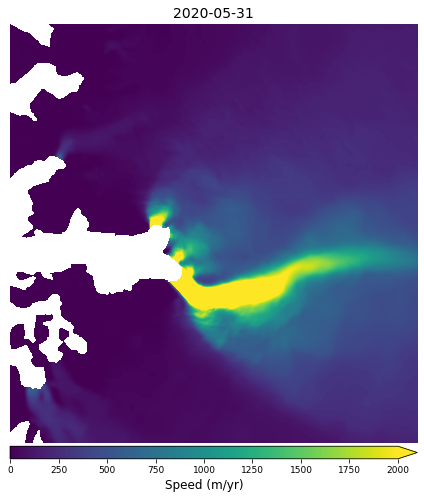

In [53]:
fig, ax = plt.subplots(1, 1, figsize=(8,8))
myVelSeries.displayVelForDate('2020-01-01', ax=ax, labelFontSize=12, plotFontSize=9, titleFontSize=14, 
                              vmin=0, vmax=2000, units='km', scale='linear', colorBarSize='3%', colorBarPosition='bottom') 
ax.axis('off');

In [50]:
help(plt.colorbar)

Help on function colorbar in module matplotlib.pyplot:

colorbar(mappable=None, cax=None, ax=None, **kw)
    Add a colorbar to a plot.
    
    Parameters
    ----------
    mappable
        The `matplotlib.cm.ScalarMappable` (i.e., `~matplotlib.image.AxesImage`,
        `~matplotlib.contour.ContourSet`, etc.) described by this colorbar.
        This argument is mandatory for the `.Figure.colorbar` method but optional
        for the `.pyplot.colorbar` function, which sets the default to the current
        image.
    
        Note that one can create a `.ScalarMappable` "on-the-fly" to generate
        colorbars not attached to a previously drawn artist, e.g. ::
    
            fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)
    
    cax : `~matplotlib.axes.Axes`, optional
        Axes into which the colorbar will be drawn.
    
    ax : `~matplotlib.axes.Axes`, list of Axes, optional
        One or more parent axes from which space for a new colorbar axes will be
      

## Interpolation

A common function with the velocity date is interpolating data for plotting points or profiles, which can be easily done with the `nisarVelSeries.interp` method.

In [24]:
# Using km
vx, vy, vv = myVelSeries.interp(*myFlowlines[glacierId].xykm(), units='km')
print(vx.shape, vx[0, 100], vy[0, 100], vv[0, 100])
# or units of meters
vx, vy, vv = myVelSeries.interp(*myFlowlines[glacierId].xym(), units='m')
print(vx.shape, vx[0, 100], vy[0, 100], vv[0, 100])
# or entirely different coordinate system
xytoll = pyproj.Transformer.from_crs(3413, 4326)
lat, lon = xytoll.transform(*myFlowlines[glacierId].xym())
vx, vy, vv = myVelSeries.interp(lat, lon, sourceEPSG=4326)
print(vx.shape, vx[0, 100], vy[0, 100], vv[0, 100])
# Or would prefer an xarray rather than nparray
result = myVelSeries.interp(*myFlowlines[glacierId].xykm(), units='km', returnXR=True)
result;

(6, 181) -77.83922891005291 -11.383531758615678 78.66828524051097
(6, 181) -77.83922891005291 -11.383531758615678 78.66828524051097
(6, 181) -77.83922891003112 -11.383531758575606 78.66828524048344


## Plot Central Flowlines at Different Times

This example will demonstrate plotting the nominally central flowline ('06') for each of the six years for which there are currently data. This example works for annual data. Minor modifications are needed for the legend if more frequent data are selected above. 

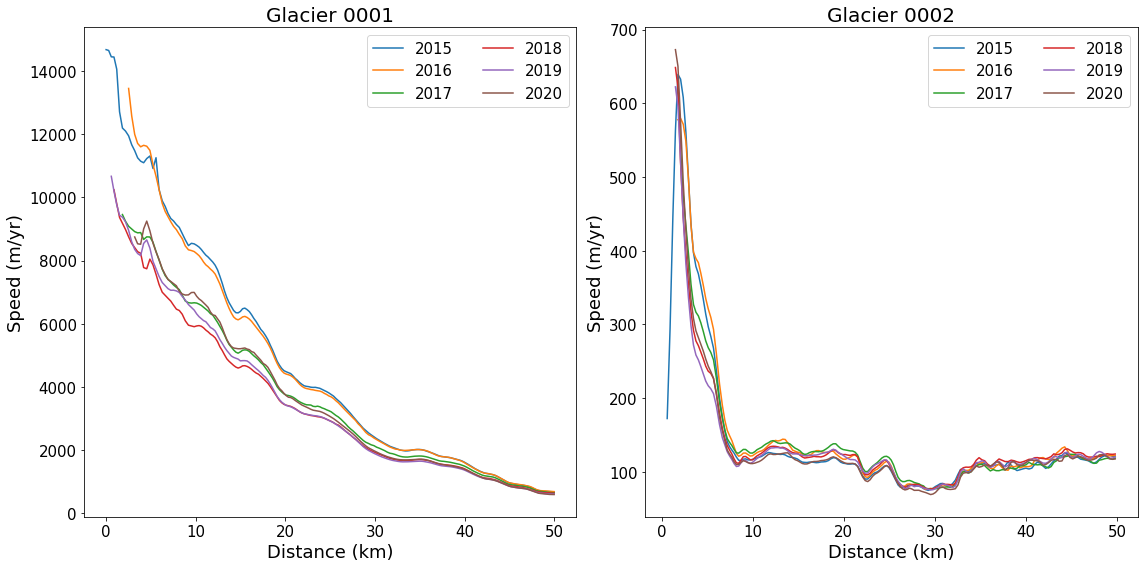

In [25]:
flowlineId ='06'  # Flowline id to plot
fig, axes = plt.subplots(np.ceil(len(myFlowlines)/4).astype(int), 2, figsize=(16, 8))  # Setup plot
# Loop over glaciers
for glacierId, ax in zip(myFlowlines, axes.flatten()):
    # return interpolated values as vx(time index, distance index)
    vx, vy, vv = myVelSeries.interp(*myFlowlines[glacierId].xykm(), units='km')
    # loop over each profile by time
    for speed, myDate in zip(vv, myVelSeries.time):
        ax.plot(myFlowlines[glacierId].distancekm(), speed, label=myDate.year)
    # pretty up plot
    ax.legend(ncol=2, loc='upper right', fontsize=15)
    ax.set_xlabel('Distance (km)', fontsize=18)
    ax.set_ylabel('Speed (m/yr)', fontsize=18)
    ax.set_title(f'Glacier {glacierId}', fontsize=20)
# For other combinations could have 
for ax in axes.flatten():
    ax.tick_params(axis='both', labelsize=15)
plt.tight_layout()

## Plot Points Through Time

When the map plots were generated above, a set of points 10-k from the start of each flowline was extracted:

In [26]:
glacierPoints

{'0001': {'03': (-176.56832111994873, -2281.0994802378723),
  '04': (-176.57938979911765, -2281.5335680932617),
  '05': (-176.57002817972838, -2281.9249696551415),
  '06': (-176.79220987043246, -2282.204119702424),
  '07': (-176.9666900075591, -2282.481895335485),
  '08': (-177.43129335281543, -2282.7171334333398)},
 '0002': {'03': (-203.39890470601097, -2244.9390773695413),
  '04': (-203.05275750822682, -2245.3549816898053),
  '05': (-203.02191562572793, -2245.7134285462275),
  '06': (-202.7513660612219, -2246.0637465671216),
  '07': (-202.46742712091572, -2246.4450735405717),
  '08': (-202.14758624325026, -2246.820176873798)}}

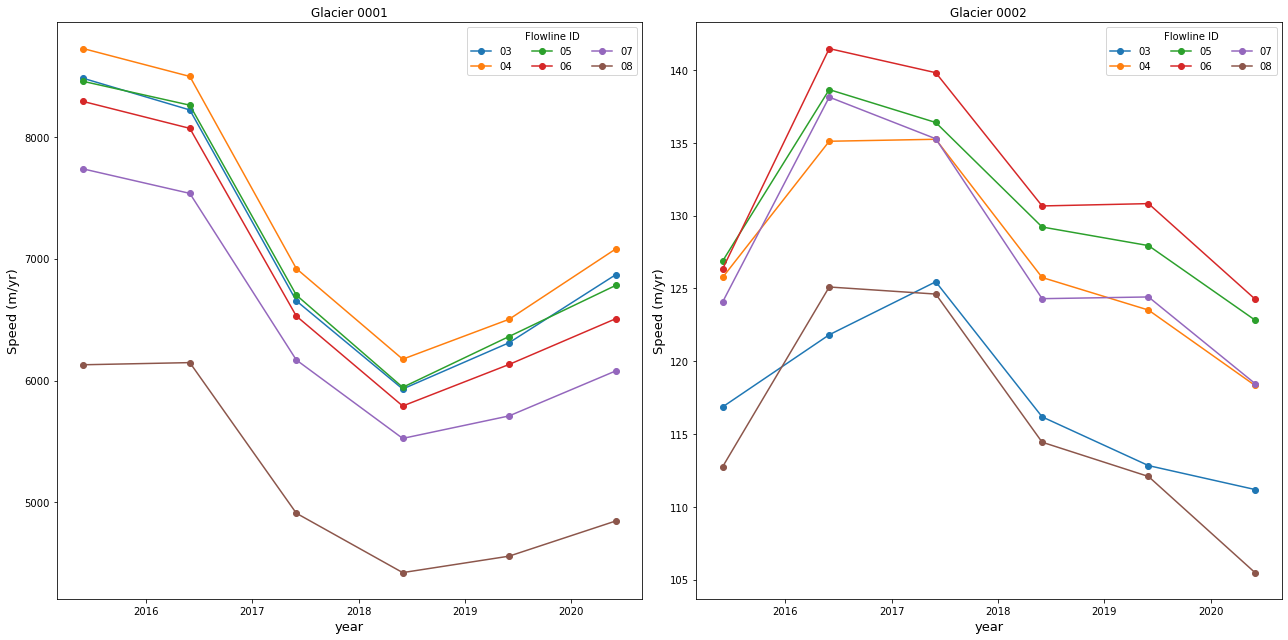

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(18, 9))
# Loop over glaciers
for glacierId, ax in zip(glacierPoints, axes.flatten()):
    # Loop over flowlines
    for flowlineId in glacierPoints[glacierId]:
        # interpolate to get results vx(time index) for each point
        vx, vy, v = myVelSeries.interp(*glacierPoints[glacierId][flowlineId], units='km')
        ax.plot(myVelSeries.time, v, marker='o',  linestyle='-', color=flowlineColors[flowlineId],label=f'{flowlineId}')
    # pretty up plot
    ax.legend(ncol=3, loc='upper right', title='Flowline ID')
    ax.set_xlabel('year', fontsize=13)
    ax.set_ylabel('Speed (m/yr)', fontsize=13)
    ax.set_title(f'Glacier {glacierId}')
plt.tight_layout()

## Save the Data

While it is convenient to work the date remotely, its nice to be be able to save the data for further processing.

The downloaded subset can be saved in a netcdf and reloaded for to `velSeries` instance for later analysis. 

Note makes sure the data have been subsetted so only the the subset will be saved (~15MB in this example). If not, the entire Greeland data set will be saved (370GB). 

Change `saveData` and `reloadData` below to test this capability.

In [28]:
saveData = False # Set to True to save data
if saveData:
    myVelSeries.toNetCDF('Glaciers1-2example.nc')

Now open open the file and redo a plot from above with the saved data.

In [29]:
reloadData = False  # Set to True to reload the saved data
if reloadData:
    fig, axes = plt.subplots(np.ceil(len(myFlowlines)/2).astype(int), 2, figsize=(16, 8))  # Setup plot
    myVelCDF = nisar.nisarVelSeries() # Create Series
    myVelCDF.readSeriesFromNetCDF('Glaciers1-2example.nc')
    #
    for glacierId, ax in zip(myFlowlines, axes.flatten()):
        # return interpolated values as vx(time index, distance index)
        vx, vy, vv = myVelCDF.interp(*myFlowlines[glacierId].xykm(), units='km')
        # loop over each profile by time
        for speed, myDate in zip(vv, myVelSeries.time):
            ax.plot(myFlowlines[glacierId].distancekm(), speed, label=myDate.year)
        # pretty up plot
        ax.legend(ncol=2, loc='upper right', fontsize=15)
        ax.set_xlabel('Distance (km)', fontsize=18)
        ax.set_ylabel('Speed (m/yr)', fontsize=18)
        ax.set_title(f'Glacier {glacierId}', fontsize=20)
# For other combinations could have 
    for ax in axes.flatten():
        ax.tick_params(axis='both', labelsize=15)
    plt.tight_layout()

# Visualizing with widgets

In [30]:
# Dotson - requires a shapefile to plot that has been formated to lists of lat/lon pairs
# formatting for shapefile: Wcoords2 = [[Wlat2[i],Wlon2[i]] for i in range(Wlat2.shape[0])]

add

center = [-74.23, -112.00]
zoom = 8

mapdt1 = '2022-02-01'

global dc, start, end, file, lon_l, lat_l, lon_r, lat_r, dt

# Pick date
start = widgets.DatePicker(disabled=False)
end = widgets.DatePicker(disabled=False)
# dt = widgets.DatePicker(disabled=False)

# Select from map
draw_control = DrawControl(rectangle={}, polyline={'shapeOptions': {'color': '#fca45d','weight': 1,'opacity': 1.0}}, 
                 polygon={}, circlemarker={})

feature_collection = {
    'type': 'FeatureCollection',
    'features': []}

def handle_draw(self, action, geo_json):
    """Do something with the GeoJSON when it's drawn on the map"""    
    feature_collection['features'].append(geo_json)

draw_control.on_draw(handle_draw)

m = Map(basemap=basemap_to_tiles(basemaps.NASAGIBS.ModisAquaTrueColorCR, mapdt1),center=center,zoom=zoom)

line1 = Polyline(locations=Wcoords1, weight=1,color='red' , fill=False)
line2 = Polyline(locations=Wcoords2, weight=1,color='red' , fill=False)
m.add_layer(line1)
m.add_layer(line2)

# Provides drawing control - can add something that keeps what is drawn...
m.add_control(draw_control)

# Can upload a shapefile
file = widgets.FileUpload(accept='.shp', multiple=False)

# Specify a bounding box
lon_l = widgets.FloatText(description="lon")
lat_l = widgets.FloatText(description="lat")
lon_r = widgets.FloatText(description="lon")
lat_r = widgets.FloatText(description="lat")

AppLayout(header = VBox([HTML("<h1>Select area (time and space)</h1>"),
                 HBox([Label("Start Date:"), start, 
                       Label("End Date:"), end]),
                 # HBox([Label("Map Date:"), mapdt1])
                        ]),
             center = m,)

NameError: name 'add' is not defined

## Summary

 🎉 Congratulations! You've completely this tutorial and have seen how we can add  notebook can be formatted, and how to create interactive map visualization with ipyleaflet.
 

```{note}
You may have noticed Jupyter Book adds some extra formatting features that do not necessarily render as you might expect when *executing* a noteook in Jupyter Lab. This "admonition" note is one such example.
```

:::{warning}
Jupyter Book is very particular about [Markdown header ordering](https://jupyterbook.org/structure/sections-headers.html?highlight=headers#how-headers-and-sections-map-onto-to-book-structure) to automatically create table of contents on the website. In this tutorial we are careful to use a single main header (#) and sequential subheaders (#, ##, ###, etc.)
:::

## References

To further explore the topics of this tutorial see the following detailed documentation:

* [Jupyter Book rendering of .ipynb notebooks](https://jupyterbook.org/file-types/notebooks.html)
* [Jupyter Book guide on writing narrative content](https://jupyterbook.org/content/index.html)
* [ipyleaflet documentation](https://ipyleaflet.readthedocs.io)